# Bayesian linear regression

Author: [Nipun Batra](https://nipunbatra.github.io/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pymc3 as pm
import arviz as az

rc('font', size=16)
rc('text', usetex=True)

Let us generate data from known parameters.

In [2]:
theta_gt = [2, 5]
X = np.random.uniform(0, 1, 100)
Y = theta_gt[0] + theta_gt[1] * X + np.random.normal(0, 1, 100)

We can see the optimal fit on this data. 

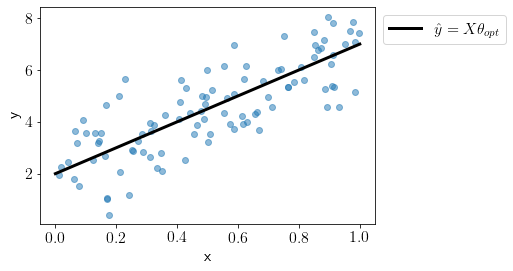

In [3]:
plt.scatter(X, Y, alpha=0.5)
x_line = np.linspace(0, 1, 1000)
y_line_gt = theta_gt[0] + theta_gt[1] * x_line
plt.plot(x_line, y_line_gt, color='k',lw=3, label='$\hat{y} = X\\theta_{opt}$');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1,1));

We can define Bayesian linear regression model in PyMC as the following,

In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    theta = pm.Normal("theta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    X_ = pm.Data('features', X)
    # Expected value of outcome
    mu = theta[0] + theta[1] * X_
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

Let us get the MAP for model paramaters.

In [5]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'theta': array([2.06886375, 4.76338553]),
 'sigma_log__': array(0.0340025),
 'sigma': array(1.03458719)}

Let us draw a large number of samples from the posterior.

In [6]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(2000,return_inferencedata=False,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


We can visualize the posterior distributions over individual paramaters as the following, 

/home/patel_zeel/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


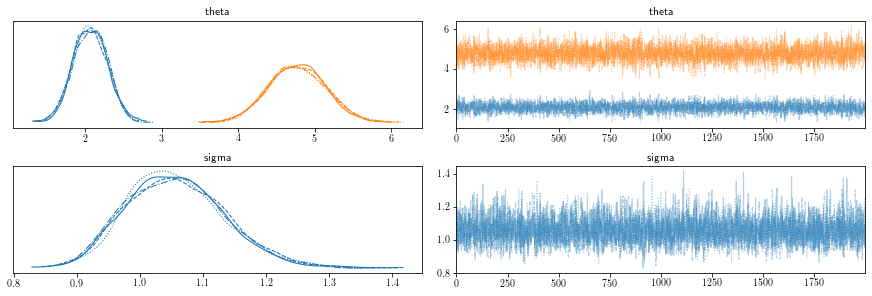

In [7]:
az.plot_trace(trace);

Below is the summary statistics of the posterior.

In [8]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],2.06,0.22,1.65,2.47,0.00,0.0,3486.19,3563.27,1.0
theta[1],4.77,0.37,4.09,5.48,0.01,0.0,3587.88,3968.01,1.0
sigma,1.06,0.08,0.92,1.21,0.00,0.0,4405.63,3833.57,1.0


Let us predict at the new input locations. This would mean to sample from the likelihood using posterior parameters.

In [9]:
x_new = np.linspace(-1, 1, 100) # 50 input values between -3 and 3
with basic_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)
    
preds = posterior['Y_obs']
preds.shape

(8000, 100)

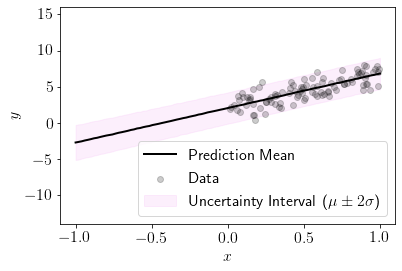

In [10]:
y_mean = np.mean(preds, axis=0)
y_std = np.std(preds, axis=0)

plt.scatter(X, Y, c='k', zorder=10, label='Data',alpha=0.2)
plt.plot(x_new, y_mean, label='Prediction Mean',color='black',lw=2)
plt.fill_between(x_new, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.12, label='Uncertainty Interval ($\mu\pm2\sigma$)',color='violet')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-14, 16)
plt.legend(loc='lower right');


We can see that uncertainty is covering 95% of the samples here and hence model is giving sensible estimate of uncertainty.

We can see that uncertainty is lower in the region where the dataset is lying.

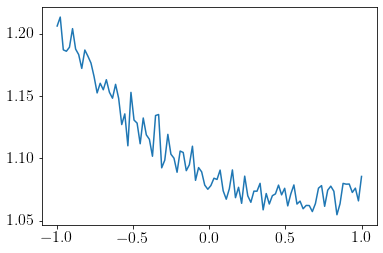

In [11]:
plt.plot(x_new, y_std);

## Laplacian Prior (LASSO)

Let us use a Laplacial prior instead of Gaussian. Note that this settings matches with Lasso regression.

In [12]:
class Lasso:
    def __init__(self, b):
        self.b = b
    
    def fit(self, X, y):
        lasso_model = pm.Model()
        self.model = lasso_model
        with self.model:

            # Priors for unknown model parameters
            theta = pm.Laplace("theta", mu=0, b=self.b, shape=2)
            sigma = pm.HalfNormal("sigma", sigma=1)
            X_ = pm.Data('features', X)
            # Expected value of outcome
            mu = theta[0] + theta[1] * X_

            # Likelihood (sampling distribution) of observations
            Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
            trace_lasso = pm.sample(1500,return_inferencedata=False,tune=500)
        self.model = lasso_model
        self.trace = trace_lasso
        
    def plot(self):
        az.plot_trace(self.trace)
        
    def predict(self, X):
        with self.model:
            pm.set_data({'features': X})
            posterior = pm.sample_posterior_predictive(self.trace)
        self.posterior = posterior

Let us draw posterior with different initial prior paramaters.

In [13]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

out = {}
regs = {}
for b in [0.02, 0.05, 0.07, 0.1, 0.2, 1]:
    print('b',b)
    reg = Lasso(b)
    reg.fit(X, Y)
    regs[b] = reg
    out[b] = reg.trace['theta']

b 0.02


b 0.05


b 0.07


b 0.1


b 0.2


b 1


Let us visualize the posterior distribution over theta.

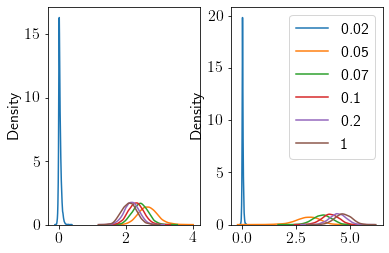

In [14]:
fig, ax = plt.subplots(ncols=2)
for i, b in enumerate([0.02, 0.05, 0.07, 0.1, 0.2, 1]):
    sns.kdeplot(out[b][:, 0], ax=ax[0], label=b)
    sns.kdeplot(out[b][:, 1], ax=ax[1], label=b)
plt.legend();

Higher values of $b$ seem to give close to the original predictions.

We define a custom function to visualize the posterior fit on the new input locations by varying initial paramaters of prior.

In [15]:
def plot_custom(b):
    reg = regs[b]
    reg.predict(x_new)
    preds = reg.posterior['Y_obs']
    y_mean = np.mean(preds, axis=0)
    y_std = np.std(preds, axis=0)
    plt.scatter(X, Y, c='k', zorder=10, label='Data',alpha=0.2)
    plt.plot(x_new, y_mean, label='Prediction Mean',color='black',lw=2)
    plt.fill_between(x_new, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.12, label='Uncertainty Interval ($\mu\pm2\sigma$)',color='violet')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.ylim(-14, 16)
    plt.legend(loc='upper left')

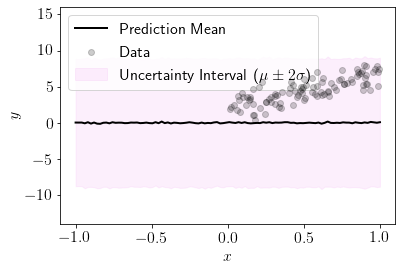

In [16]:
plot_custom(0.02)

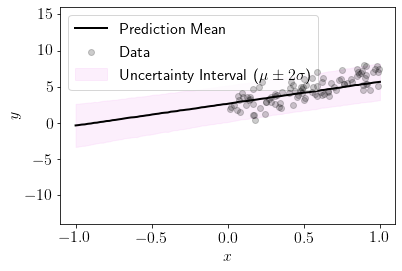

In [17]:
plot_custom(0.05)

We can see that for $b=0.05$ model is giving sensible predictions.